In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Limitations of Fixed Basis Functions
Or: *Why single-layer linear models like regression aren't enough*

Linear models for classification (like logistic regression) are based on linear combinations of basis functions $\phi_j(\mathbf{x})$ and take the form:
$$y(\mathbf{x}, \mathbf{w}) = f \bigg(\sum_{j=1}^M w_j\phi_j(\mathbf{x}) + w_0\bigg)$$
Where $f(\cdot)$ is a nonlinear output activation function (like softmax or sigmoid). OLS takes the same form but replaces $f(\cdot)$ with the identity activation function (aka. link function).

Because general linear models allow for an arbitrary set of nonlinear basis functions $\{\phi_i(\mathbf{x})\}$, the can in principal provide a solution to *any* regression or classification problem.

### The Curse of Dimensionality

Let's examine some characteristics of high-dimensional spaces. Consider a hypersphere in $D$-dimensional space with radius $r=1$. What fraction of the hypersphere's volumne lies between radius $r=1-\epsilon$ and $r=1$?\
Let volume be: $$V_D(r) = K_Dr^D$$ Where $K_D$ is a constant that depends only on the dimensions $D$.\
The fraction of total volume is given by: $$\frac{V_D(1) - V_D(1-\epsilon)}{V_D(1)} = 1 - (1-\epsilon)^D$$

As $D$ increases, this fraction increases towards $1$, even for very small $\epsilon$. Ex:

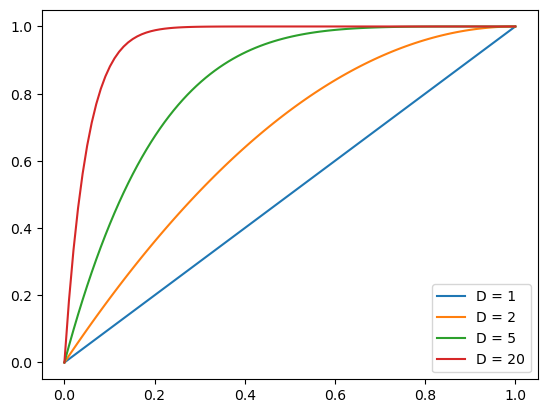

In [16]:
def volume(D, eps): return 1 - (1 - eps)**D

eps = np.linspace(0, 1, 100)
for D in [1, 2, 5, 20]:
    plt.plot(eps, [volume(D=D, eps=eps) for eps in eps], label=f"D = {D}");
plt.legend();

So, we see a remarkable result that in spaces of high dimensionality, most of the volume of the hypersphere becomes concentrated in a thin shell near its surface...\
As dimensions increase, the distance between points increases exponentially, causing effictive sparsity in datasets to increase exponentially.

### Data Manifolds

One reason that ML techniques can be effective despite the curse of dimensionality is that real data are generally confined to regions of space that have lower effective dimensionality.

See `data_manifolds` notebook.

## Multilayer Networks

In general, we want to choose basis functions $\phi_j(\mathbf{x})$ that have *learnable* parameters and that are *differentiable* (so that we may optimize them via gradient descent). The most successful choice of basis functions has been a nonlinear basis function of the form:
$$y(\mathbf{x}, \mathbf{w}) = f \bigg(\sum_{j=1}^M w_j\phi_j(\mathbf{x}) + w_0\bigg)$$

This is a nonlinear function of a *linear combination* of the input variables, where the coefficients in the linear combination are learnable parameters.


Consider a model with two layers. We will use the superscript $(i)$ to indicate layer $i$. The *pre-activation* for the first layer is a set of $M$ linear combinations of $D$ input variables:
$$a_j^{(1)} = \sum_{i=1}^D w_{ji}^{(1)} x_i + w_{j0}^{(1)}, \  \ j=1, ..., M$$
Here, $w_{ji}^{(1)}$ are the *weights* of combination $j$ and $w_{j0}^{(1)}$ is the *bias* of combination $j$. The quantity $a_j^{(1)}$ is the *pre-activation*, which is transformed into an *activation* using a differentiable, nonlinear activation function:
$$z_j{(1)} = h(a_j^{(1)})$$
This activation is analagous to a basis function. Because this is not the final layer of the network, this layer's basis functions are called *hidden units*

The second layer has preactivations specified as:
$$a_k^{(2)} = \sum_{j=1}^M w_{kj}^{(2)}z_j^{(1)} + w_{k0}^{(2)}, \ \ k=1, ..., K$$
Where $K$ is the total number of outputs. Note that this is again a simple set of linear combinations, only the input variables are now the activations $z_j^{(1)}$ rather than the input variables. Finally, this preactivation is transformed by a function $f(\cdot)$ to a set of network outputs $y_k$.

The nomenclature for each $j$ of the $M$ linear combinations is to call them *neurons*.

We may consolidate the notation by defining an additional input variable $x_0 = 1$, so the first preactivation may be expressed as:
$$a_j = \sum_{i=0}^D w_{ji}^{(1)}x_i$$
Then, the function for $y_k$ may be expressed as:
$$y_k(\mathbf{x}, \mathbf{w}) = f \Bigg(\sum_{j=0}^M w_{kj}^{(2)} h \bigg(\sum_{i=0}^D w_{ji}^{(1)} x_i \bigg) \Bigg)$$
Note that this complete expression may be viewed as a set of $M$ basis functions.

If we express the input variables as a column vector $\mathbf{x} = (x_i, ..., x_N)^\intercal$, then these linear combinations may be expressed with matrix multiplication:
$$\mathbf{y}(\mathbf{x}, \mathbf{w}) = f\bigg(\mathbf{W}^{(2)} h\big(\mathbf{W}^{(1)}\mathbf{x}\big)\bigg)$$

### Activation Functions

There is a lot of nuance in the choice of activation functions, but the treatment here is fairly high-level. 

The most basic activation function is simply the identity:
$$h(a) = a$$
In this case, the hidden layer activations are simply a linear combination of the inputs. If the network only has identity activations, then it is a linear function of the inputs. It corresponds to a linear model.

In general, we want differentiable activation functions (with some exception) so that we may learn parameters of hidden layers via gradient descent. 

**Sigmoid Activation Function**
$$\sigma(a) = \frac{1}{1 + \exp(-a)}$$
The 'ole reliable. This is a simple, nonlinear, continuously differentiable activation function.

**tanh Activation Function**
$$\text{tanh}(a) = \frac{e^a - e^{-a}}{e^a + e^{-a}} = 2\sigma(2a) - 1$$
A close relative of the sigmoid activation function is the hyperbolic-tangent activation function, or simply *tanh*.

**Hard tanh Activation Function**
$$h(a) = \text{max}(-1, \text{min}(1, a))$$
This mimics the tanh activation but fixes its limits to $-1$ or $1$. Note that the tanh function asymptotically approaches $-1$ as $x\rightarrow - \infty$ and $1$ as $x \rightarrow \infty$.

*See `log_reg_basis_functions` for investigation of these activation functions*

A significant issue with these activation functions is that their gradients exponentially decay towards zero when the inputs to their layers have large values. This leads to the issue of ***vanishing gradients*** discussed later. Some of the following activation functions ameliorate this:

**Softplus Activation Function**
$$h(a) = \ln(1 + \exp(a))$$
$h(a)$ approximates $a$ for very large values of $a$, ensuring that gradients will remain non-zero.

**ReLU Activation Function**
$$h(a) = \text{max}(0, a)$$
The "rectified linear unit" activation function simply zeros-out negative preactivations. This activation function is widely used because it is very efficient and computationaly inexpensive. Note that it is *not continuously differentiable* because the derivative of the ReLU function is not defined at $a=0$. However, this doesn't prevent training by gradient descent because we simply zero-out gradients for negative $a$ and chain gradients through linearly (i.e. as identity) for posistive $a$. Because ReLU is intentionally zero-ing out gradients there are some precautions that must be observed when training with ReLU. Some of these I explored in the notebook `sinenet`. Notably, we must be careful not to train too quickly (we don't want to kill neurons early in the training process), we want generally larger networks (more neurons) so that there are fewer possibilities for neurons to be killed prematurely, and we want to use effective training batch sizes so that the information used to update each neuron's parameters at each step of training is sufficiently *stochastic* and not washed out by using aggregate information over the entire training set. Also, ReLU may be more sensitive to parameter initializations (in some ways) because negative activations in an initial training step may prevent some neurons from *ever* learning.

**Leaky ReLU**
$$h(a) = \max(0,a) + \alpha \min(0, a), \ \ 0 < \alpha < 1$$
Leaky ReLU relaxes the positive-value bottleneck applied by ReLu by adding a scaled-down value of the negative preactivations to propogate forwards through the network, ensuring that gradients are nonzero for $a<0$. This ensures that we won't prematurely kill neurons. 

Softplus may also be viewed as a somewhat more relaxed, "leaky", ReLU since it converges to $0$ for $a<0$.

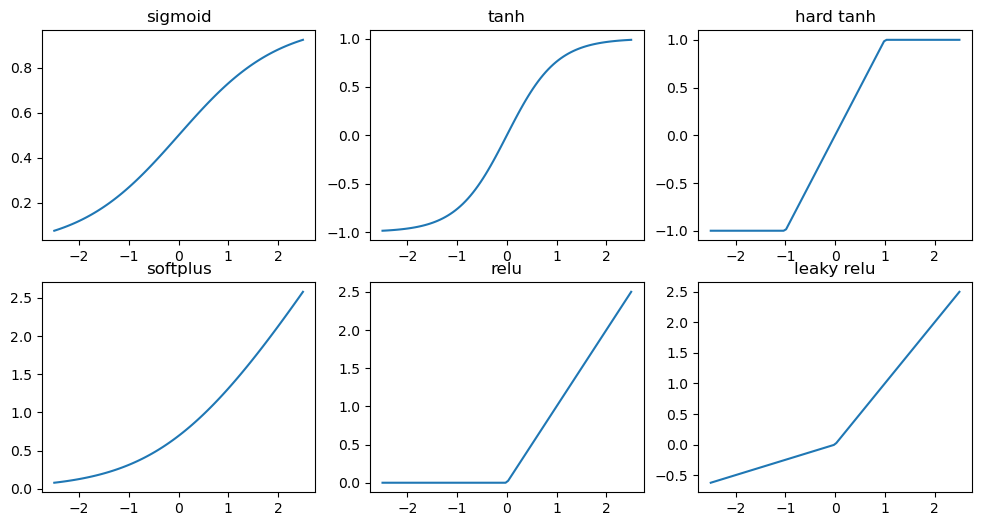

In [19]:
x = np.linspace(-2.5, 2.5, 100)
def sigmoid(x):             return 1 / (1 + np.exp(-x))
def tanh(x):                return 2*sigmoid(2*x) - 1
def hard_tanh(x):           return np.clip(x, -1, 1)
def softplus(x):            return np.log(1 + np.exp(x))
def relu(x):                return np.maximum(0, x)
def leaky_relu(x, alpha):   return relu(x) + alpha * np.minimum(0, x)

fig, ax = plt.subplots(2, 3, figsize=(12, 6))
ax[0, 0].plot(x, sigmoid(x))
ax[0, 0].set_title('sigmoid')
ax[0, 1].plot(x, tanh(x))
ax[0, 1].set_title('tanh')
ax[0, 2].plot(x, hard_tanh(x))
ax[0, 2].set_title('hard tanh')
ax[1, 0].plot(x, softplus(x))
ax[1, 0].set_title('softplus')
ax[1, 1].plot(x, relu(x))
ax[1, 1].set_title('relu')
ax[1, 2].plot(x, leaky_relu(x, 0.25))
ax[1, 2].set_title('leaky relu')


plt.show();

### Weight-Space Symmetries

Multiple distinct choices for the weights parameterized in the weights vector $\bf w$ can all give rise to the same mapping function from inputs to outputs. Many equivalent weight combinations may be found by systematically changing the signs on weights (depending on the activation function). For $M$ hidden units, there are $M$ 'sign-flip' symmetries, giving rise to $2^M$ qeuivalent weight vectors. Similarly, we may interchange weights between hidden units within the same layer. This is an elementary row operation upon the weights matrix (that does not change scale), meaning that the matrix is fundamentally unchanged and so produces an equivalent matrix. There are $M!$ such combinations achievable for $M$ hidden units.

In total, for a hidden layer with $M$ hidden units, we have $M!2^M$ equivalent weight combinations, this is the layer's ***weight-space symmetry factor***.

## Deep Networks

We may extend the two-layer network architecture to any finite number $L$ of layers. The vector of activations for layer $l \ \in L$ is given by:
$$\mathbf{z}^{(l)} = h^{(l)} \big( \mathbf{W}^{(l)}\mathbf{z}^{(l-1)} \big)$$
In this framework, $\mathbf{z}^{(0)} = \mathbf{x}$ represents the input vector and $\mathbf{z}^{(L)} = \mathbf{y}$ represents the output vector.

### Hierarchical Representations

Deep networks can encode useful forms of *[inductive biases](https://en.wikipedia.org/wiki/Inductive_bias)* - "namely that the outputs are related to the input space through a hierarchical representation." AlexNet demonstrates this very well for image recognition, showing how earlier layers learn edge-detection, then color gradients, then primary shapes, all the way up to the dominant semantic features that distinguish a picture of a cat from a picture of a dog. This is a *compositional inductive bias* in which higher-level objects like a cat are composed of lower-level objects like eyes or whiskers, which are composed of still lower-level objects like edges.

### Distributed Representations

Deep networks also take advantage of *distributed representation*. We may consider each unit of a hidden layer as representing a 'feature' at that level of the network. A high activation (high value) in the unit indicates the presence of that feature while a low activation indicates its absence. With $M$ units in a layer, the network can represent $M$ distinct features. However, networks also learn representations through *combinations* of hidden units. With $2^M$ combinations possible, the network may learn $2^M$ different feature representations. In practice, networks often have some hidden units that appear dedicated to distinct features and other hidden units that appear to share representations amongst each other. We can also find hidden units that seem to distinctly represent one feature while also jointly representing other features.

Essentially, the capacity for networks to learn distributed representations improves their efficiency because it allows the network to learn representations for more features with fewer hidden units (neurons).

### Representation Learning

*Representation Learning* refers to the ability of deep networks to discover nonlinear transformations of datasets that makes subsequent tasks easier to solve. The learned representation is a point or surface in the *embedding space* given by the outputs of one of the hidden layers of the network, so that any input vector may be transformed into the respresentation (mapped onto the surface in the embedding space) by forward propogation through the network.

This is basically the manifold hypothesis.

### Transfer Learning

Internal representations learned for one task may be useful for other, related, tasks. This is the motivation behind transfer learning. A common example may be training a model on a large generalized dataset and then fine-tuning it for smaller, more specific use cases. 

### Contrastive Learning

Objective is to learn representations such that certain pairs of inputs, called *positive pairs*, are close together in the embedding space while other *negative pairs* are far apart. The distance between pairs is a representation of their semantic similarity. 

The error function for a given input in contrastive learning is only defined with respect *to other inputs*, instead of having a per-input label or target output as in generic classification. For a given data point $\bf x$, called the *anchor*, we define a positive point $\bf x^+$ and a set of negative points $\{\bf x_1^-, ..., x_N^-\}$ which make up negative pairs with the anchor $\bf x$. Then, the loss function is specified such that close proximity between *representations* of $\bf x$ and $\bf x^+$ are rewarded close distances between *representations* of $\bf x$ and $\bf x_n^-$ are penalized. A common loss function is *InfoNCE* loss ('noise contrastive estimation') which I'm not going to bother noting here. Basically, it resembles cross-entropy loss where the logits for the correct classification are substituted with the cosine similarity between the anchor and the positive point while the incorrect class logits are substituted with the cosine similarities between the anchor and the negative points.

Contrastive learning has been used across modalities, notably for labeling, or captioning, images via 'contrastive-language image pretraining' or CLIP.

### General Network Architecture

The general form of a feed-forward network:
$$z_k = h \Bigg( \sum_{j\in \mathcal{A}(k)} w_{kj}z_j + b_k \Bigg)$$
Where $\mathcal{A}(k)$ denotes the *ancestors* of node $k$; that is, the set of units (neurons) which send connections to the unit $k$.

### Tensors

For our purposes, tensors are simply arrays of arrays. For example, a tensor $\bf X$ of image data may have elements $x_{ijkn}$ where $i \in \{1, ..., I\}$ and $j \in \{1, ... J\}$ index the pixel row and column of the image; $k \in \{1, 2, 3\}$ indexes the red, green, and blue intensities, and $n \in \{1, ..., N\}$ indexes the particular image within the dataset.

Processes applied over tensors typically are applied as parallelizations across the tensors' matrix elements (e.g. $i$ and $j$). For example, when processing images in RGB, we will typically do the ordinary matrix operations across the hyperdimensions of $i$ and $j$ separately and in parallel for each color $k \in \{1,2,3\}$. The value of the hyperdimension $k$ denotes the number of *channels* in the network. 

## Error Functions

### Regression
Assume that $t$ has a Gaussian distribution with an $\bf x$-dependent mean. This is a fairly restrictive assumption that corresponds to the OLS framework. The conditionaly probability density function is then:
$$p(t|\mathbf{x}, \mathbf{w}) = \mathcal{N}(t|y(\mathbf{x}, \mathbf{w}), \sigma^2)$$
Where $\sigma^2$ is the variance of the Gaussian noise.\
When modeling such a variable, we may use the identity activation function for the final network layer (identity link function).\
The likelihood function is given by:
$$p(\mathbf{t}|\mathbf{X}, \mathbf{w}, \sigma^2) = \prod_{n=1}^N p(t_n|y(\mathbf{x}_n, \mathbf{w}), \sigma^2)$$
Maximizing this likelihood function is equivalent to minimizing the parameter-dependent term of its negative log-likelihood, i.e.:
$$E(\mathbf{w}) = \frac{1}{2}\sum_{n=1}^N \big(y(\mathbf{x}_n, \mathbf{w}) - t_n \big)^2$$
The optimal parameter value found through this minimization is denoted $\bf w^*$

**NOTE:**\
The nonlinearity of the network function $y(\mathbf{x}_n, \mathbf{w})$ may cause the error $E(\mathbf{w})$ to be *non-convex*; thus, the optimization may only find a local-minimum and not the global minimum. So, the solution found by a neural network that minimizes this error function may be different than the maximum-likelihood solution.

Having found $\bf w^*$, $\sigma^{2*}$ may be found as:
$$\sigma^{2*} = \frac{1}{N}\sum_{n=1}^N \big(y(\mathbf{x}_n, \mathbf{w}^*) - t_n\big)^2$$

### Binary Classification

$$t = \begin{cases} 0, \ \ if \mathcal{C}_1 \\ 1, \ \ if \mathcal{C}_2 \end{cases}$$
Using the logistic sigmoid activation function for the final output, we may ensure that $0 \le y(\mathbf{x}_n, \mathbf{w}) \le 1$. Then, the conditional distribution of targets given inputs is a Bernoulli distribution of the form:
$$p(t|\mathbf{x}_n, \mathbf{w}) = y(\mathbf{x}, \mathbf{w})^t\big[1 - y(\mathbf{x}, \mathbf{w})\big]^{1-t}$$
The negative log-likelihood is then a *cross-entropy* error of the form:
$$E(\mathbf{w}) = -\sum_{n=1}^N \big[t_n \ln y_n + (1 - t_n)\ln(t-y_n)\big]$$
Where $y_n$ denotes $y(\mathbf{x}_n, \mathbf{w})$

### Multi-Class Classification

Here, the objective is to assign each input to one of $K$ mutually exclusive classes. Network outputs may be interpreted as $y_k(\mathbf{x}, \mathbf{w}) = p(t_k=1|\mathbf{x})$. The error function is then the multi-class generalization of the cross-entropy error function:
$$E(\mathbf{w}) = - \sum_{n=1}^N \sum_{k=1}^K t_{kn} \ln y_k (\mathbf{x}_n, \mathbf{w})$$

The activation function used for the output layer is typically the softmax activation (which corresponds to the canonical link function):
$$y_k(\mathbf{x}, \mathbf{w}) = \frac{\exp(a_k(\mathbf{x}, \mathbf{w}))}{\sum_j \exp(a_j(\mathbf{x}, \mathbf{w}))}$$

## Mixture Density Networks

This section considers the outputs of networks as being *parameters* of more complex distributions (rather than simply being predicted conditional probabilities). Specifically, Gaussian mixture models.

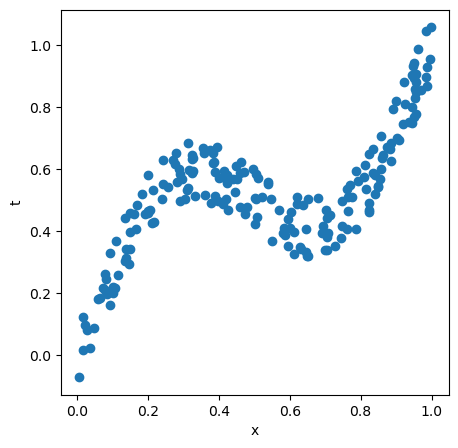

In [103]:
# toy data
x = np.random.uniform(0, 1, 200)
t = x + 0.3 * np.sin(2*np.pi *x) + np.random.uniform(-0.1, 0.1, 200)
plt.figure(figsize=(5,5))
plt.ylabel('t')
plt.xlabel('x')
plt.scatter(x, t);

In [2]:
import torch; import torch.nn as nn; import torch.nn.functional as F
from collections import OrderedDict

torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class RegNet(nn.Module):
    def __init__(self, activation: str, n_hidden):
        super().__init__()
        self.losses = []
        self.loss = nn.MSELoss()
        self.activation = nn.ReLU() if activation.lower() == 'relu' else nn.Tanh()
        self.layers = nn.Sequential(
            OrderedDict([
                ('l1', nn.Linear(1, n_hidden)),  # input layer
                ('act1', self.activation),       # input layer activation
                ('l2', nn.Linear(n_hidden, 1)),  # output layer
                ('link', nn.Identity())          # final activation (i.e. link function)
            ])
        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
    
    def forward(self, x, y):
        if not isinstance(x, torch.Tensor):
            x = torch.FloatTensor(x)
        x = x.type(torch.FloatTensor)
        res = self.layers(x)
        return res, self.loss(res, y)
    
    def train(self, x, y, epochs: int=1000, batch_size: int = 10):
        x = x.type(torch.FloatTensor)
        y = y.type(torch.FloatTensor)

        for epoch in range(epochs):
            for batch in range(len(x) // batch_size):
                batch_indices = torch.randint(low=0, high=len(x), size=(batch_size,))
                preds, loss = self.forward(x=x[batch_indices], y=y[batch_indices])
                self.losses.append(loss.item())

                self.optimizer.zero_grad()  # clear gradients
                loss.backward()             # update gradients
                self.optimizer.step()       # update weights


In [104]:
x = torch.tensor(x).view(-1, 1)
t = torch.tensor(t).view(-1, 1)

In [119]:
model1 = RegNet('tanh', n_hidden=16)
model2 = RegNet('tanh', n_hidden=16)

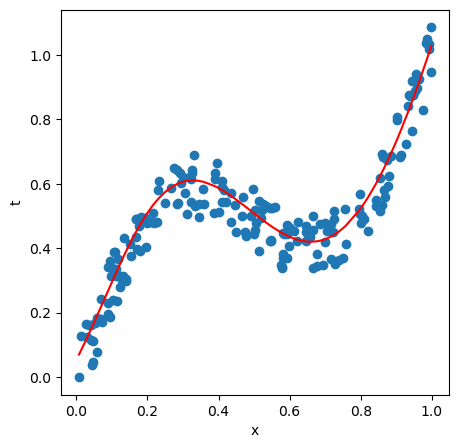

In [120]:
# model trained on x to predict t
model1.train(x, t, epochs=5000, batch_size=20)

preds = model1.forward(
        torch.sort(x.view(-1))[0].view(-1, 1), 
        torch.sort(t.view(-1))[0].view(-1, 1)
    )[0]
preds = preds.detach().numpy().reshape(-1)

plt.figure(figsize=(5,5))
plt.ylabel('t')
plt.xlabel('x')
plt.scatter(x, t)
plt.plot(torch.sort(x.view(-1))[0].view(-1, 1), preds, color='red');

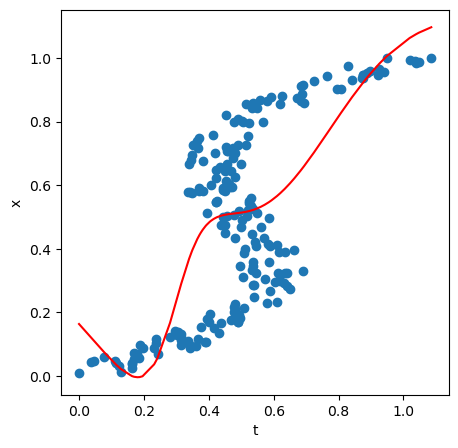

In [125]:
# model trained on t to predict x
model2.train(t, x, epochs=15000, batch_size=20)

preds = model2.forward(
        torch.sort(t.view(-1))[0].view(-1, 1),
        torch.sort(x.view(-1))[0].view(-1, 1), 
    )[0]
preds = preds.detach().numpy().reshape(-1)
plt.figure(figsize=(5,5))
plt.ylabel('x')
plt.xlabel('t')
plt.scatter(t, x)
plt.plot(torch.sort(t.view(-1))[0].view(-1, 1), preds, color='red');

When we exchange the roles of $x$ and $t$, the conditional distribution becomes bimodal, so we achieve a much poorer fit despite using the exact same network architecture. If we ignore the added noise, this function is clearly no longer injective. That is, the same value of an input (e.g. $t=0.5$) maps to multiple values of the output (e.g. $x\approx\{0.2, 0.4, 0.8\}$). So, it is very difficult for the network to accurately determine a good fit for a given input value.

We will model $p(\bf t| x)$ as a Gaussian mixture model where both the mixing coefficients and the component densities are flexible functions of the input vector $\bf x$. The modeled conditional probailities will have the form:
$$p(\mathbf{t}|\mathbf{x}) = \sum_{k=1}^K \pi_k(\mathbf{x}) \mathcal{N}(\mathbf{t}|\mathbf{\mu}_k(\mathbf{x}), \ \sigma^2_k(\mathbf{x}))$$
This is a ***Heteroscedastic Model*** because the noise variance is a function of the input $\bf x$, and therfore is not constant.

Suppose that the are $K$ components (clusters) in the GMM and that there are $L$ observations for the target variable $t$. Then the model needs to predict the following preactivations:
- $K$ preactivations for the mixing coefficients $\pi_k(\bf x)$; denoted $a_k^\pi$
- $K$ preactivations for the Gaussian standard deviations $\sigma_k(\bf x)$; denoted $a_k^\sigma$
- $K \times L$ preactivations for the components $\mu_{kj}(\bf x)$ of the Gaussian means $\mathbf{\mu}_k(\bf x)$; denoted $a_{kj}^\mu$
    - So, we predict the conditional expected value for each $t_j \in \bf t$ for each cluster $k \in K$

**Remark**: I'm pretty sure that the notation here means that $L$ is the number of elements in a vector $\bf t$ that describes *one* observation, not a set of observations. The notation $N$ is reserved to indicate the number of observations. So, in our toy example where each $t_n$ is a point, $L=1$

Appropriate activations for each are:
$$\pi_k(\mathbf{x}) = \frac{\exp(a_k^\pi)}{\sum_{l=1}^K\exp(a_l^\pi)}; \ \text{softmax, ensures that } \ \sum_{k=1}^K \pi_k(\mathbf{x}) = 1$$
$$\sigma_k(\mathbf{x}) = \exp(a_k^\sigma)$$
$$\mu_{kj}(\mathbf{x}) = a_{kj}^\mu$$

The error function may then be specified as the negative log-likelihood error:
$$E(\mathbf{w}) = - \sum_{n=1}^N\ln \bigg\{\sum_{k=1}^K \pi_k(\mathbf{x}_n, \mathbf{w})\mathcal{N}\big(\mathbf{t}_n|\mathbf{\mu}_k(\mathbf{x}_n, \mathbf{w}), \ \sigma_k^2(\mathbf{x}_n, \mathbf{w})\big)\bigg\}$$

So, we should have $3K$ total outputs for this toy example. How should we structure the loss function? Maybe we broadcast $\bf x$ across three channels, each with $K$ outputs that form a $3 \times K$ matrix, each row of which feeds a different parameter in the loss function. So, the loss could be evaluated over the columns of the output matrix...

In [148]:
import torch.distributions as dist
def gmm_loss(res):
    t = res[:, :, 0]
    pi = res[:, :, 1]
    mu = res[:, :, 2]
    sigma = res[:, :, 3]

    gaussian = dist.Normal(mu, sigma)  # normal dist for each channel
    log_probs = gaussian.log_prob(t) + torch.log(pi)  # equiv ln(pi * p(t))

    # sum over channels & observations (dim=0) and (dim=1)
    loss = -(log_probs).sum()
    return loss

Let's try to bundle this up into a model. First, we need to adapt PyTorch's `nn.Linear` object to support the $K$ channels that we want to train:

In [118]:
class ChannelLinear(nn.Module):
    def __init__(self, in_features, out_features, K=3):
        super().__init__()
        # create separate linear layers for each channel
        self.channels = nn.ModuleList([
            nn.Linear(in_features, out_features)
            for _ in range(K)
        ])

    def forward(self, x):
        x = x.type(torch.FloatTensor)
        res = torch.stack([
            self.channels[i](x[i]) for i in range(len(self.channels))  # this enables each channel to take a sequential input
        ], dim=0)  # [K, batch_size, out_features]
        return res
    

In [161]:
class gmmNet(nn.Module):
    def __init__(self, n_hidden, K):
        super().__init__()
        self.losses = []
        self.K = K
        self.l1 = ChannelLinear(1, n_hidden, K)
        self.l2 = ChannelLinear(n_hidden, 3, K)

    def forward(self, x):
        x = x.expand(self.K, -1, -1)  # expand to channels

        # forward through the network
        x = F.tanh(self.l1(x))
        x = self.l2(x)
        
        # average over batch dimension
        x = x.mean(dim=1)  # [K, 3]

        # apply output layer activations
        pi = torch.softmax(x[:, 0], dim=0)  # ensure pi sumas to 1
        mu = x[:, 1]                        # identity activation
        sigma = torch.exp(x[:, 2])          # ensure sigma is positive

        # stack parameter estimates
        res = torch.stack([pi, mu, sigma], dim=1)  # [3, 3] 

        return res

    def _reshape_params(self, params, t):
        # match shapes
        N = t.shape[0]
        params = params.unsqueeze(1).expand(-1, N, -1)  # [K, batch_size, 3]
        t = t.unsqueeze(0).expand(self.K, -1, -1)       # [K, batch_size, 1]

        # concatenate along dim 2
        res = torch.cat([t, params], dim=2)  # [K, batch_size, 4]
        return res
    
    def train(self, x, t, lr: float = 0.001, epochs: int = 1000, batch_size: int = 10):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        for epoch in range(epochs):
            for batch in range(len(x) // batch_size):
                batch_indices = torch.randint(low=0, high=len(x), size=(batch_size,))
                params = self.forward(x=x[batch_indices])
                output = self._reshape_params(params, t[batch_indices])
                loss = gmm_loss(output)

                optimizer.zero_grad()  # clear gradients
                loss.backward()        # update gradients
                optimizer.step()       # update weights

            self.losses.append(loss.item())

In [162]:
model = gmmNet(n_hidden=16, K=3)

In [163]:
model.train(t, x, lr=0.001, epochs=1000, batch_size=20)

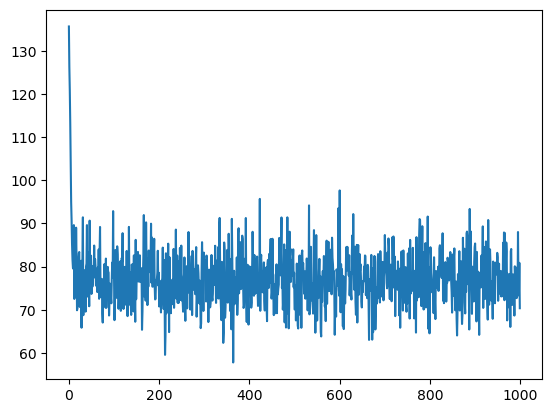

In [164]:
plt.plot(model.losses);

In [165]:
params = model.forward(t)

In [167]:
params

tensor([[0.3333, 0.5415, 0.2878],
        [0.3333, 0.5396, 0.2880],
        [0.3334, 0.5373, 0.2867]], grad_fn=<StackBackward0>)

ValueError: x and y must have same first dimension, but have shapes (200, 1) and (3,)

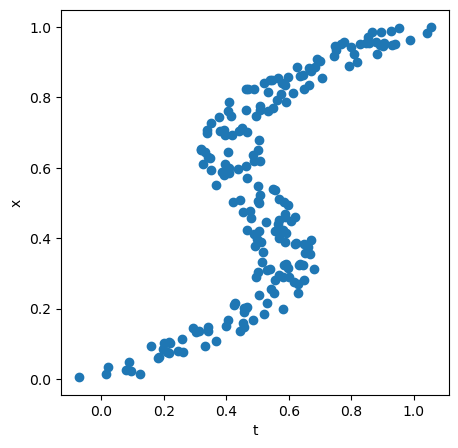

In [159]:
# model trained on t to predict x
preds = model.forward(
        torch.sort(t.view(-1))[0].view(-1, 1),
    )[0]
preds = preds.detach().numpy().reshape(-1)
plt.figure(figsize=(5,5))
plt.ylabel('x')
plt.xlabel('t')
plt.scatter(t, x)
plt.plot(torch.sort(t.view(-1))[0].view(-1, 1), preds, color='red');